In [1]:
import sys
import os

# Make project root importable regardless of where Jupyter is launched from
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

import numpy as np
import scipy
import torch
from PIL import Image
import torchvision.transforms as T
from matplotlib import pyplot as plt

from pnpflow.utils import load_cfg_from_cfg_file, define_model, load_model

/home/pourya/miniconda3/envs/flower/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/home/pourya/miniconda3/envs/flower/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ── Configuration ──────────────────────────────────────────────────────────────
ROOT    = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
dataset = 'afhq_cat'
model_variant = 'ot'

# Load and merge base config, dataset config, and method config
cfg = load_cfg_from_cfg_file(os.path.join(ROOT, 'config/main_config.yaml'))
cfg.update(load_cfg_from_cfg_file(os.path.join(ROOT, f'config/dataset_config/{dataset}.yaml')))

method_config_file = os.path.join(ROOT, f'config/method_config/{cfg.method}.yaml')
cfg.update(load_cfg_from_cfg_file(method_config_file))

method_cfg = load_cfg_from_cfg_file(method_config_file)
cfg.dict_cfg_method = {k: cfg[k] for k in method_cfg.keys()}

cfg.root = ROOT + '/'

In [3]:
# ── Device & Model Initialisation ─────────────────────────────────────────────
device = 'cuda:0'   # change to 'cpu' if no GPU is available
cfg.device = device

model, state = define_model(cfg)
print(f'Model initialised on {device}.')

Model initialised on cuda:0.


In [4]:
# ── Load Pre-trained Weights ───────────────────────────────────────────────────
model_path = os.path.join(ROOT, 'model', dataset, model_variant, 'model_final.pt')
load_model(model_variant, model, state, download=False,
           checkpoint_path=model_path, dataset=None, device=device)
model.eval()
model = model.to(device)
print('Weights loaded successfully.')

/home/pourya/Flower/pnpflow/utils.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Weights loaded successfully.


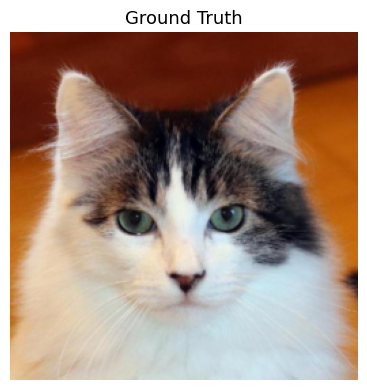

In [5]:
# ── Load & Display Test Image ──────────────────────────────────────────────────
image_path = os.path.join(ROOT, 'flower_demo', 'test_image.jpg')
img = Image.open(image_path).convert('RGB')
transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
gt = transform(img).unsqueeze(0).to(device)   # [1, 3, 256, 256], values in [0, 1]

plt.figure(figsize=(4, 4))
plt.imshow(gt.squeeze(0).permute(1, 2, 0).cpu().clamp(0, 1))
plt.title('Ground Truth', fontsize=13)
plt.axis('off')
plt.tight_layout()
plt.show()

Mask sparsity: 29.90% of k-space sampled


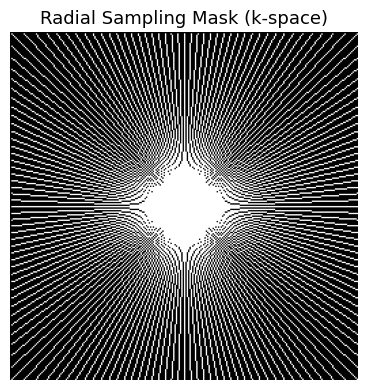

In [6]:
# ── Radial Sampling Mask & Measurement Operators ───────────────────────────────
mask_path = os.path.join(ROOT, 'flower_demo', 'radial_mask.mat')
mat  = scipy.io.loadmat(mask_path)
mask = torch.from_numpy(mat['mask']).float().to(device).view(1, 1, 256, 256)

sparsity = torch.sum(mask) / mask.numel()
print(f'Mask sparsity: {sparsity:.2%} of k-space sampled')

plt.figure(figsize=(4, 4))
plt.imshow(torch.fft.fftshift(mask)[0, 0].cpu(), cmap='gray')
plt.title('Radial Sampling Mask (k-space)', fontsize=13)
plt.axis('off')
plt.tight_layout()
plt.show()


def H(x):
    """Forward operator: 2-D FFT followed by radial undersampling."""
    return torch.fft.fft2(x, norm='ortho') * mask


def Ht(x):
    """Adjoint operator: zero-fill missing k-space lines then inverse 2-D FFT."""
    return torch.real(torch.fft.ifft2(x * mask, norm='ortho'))

In [7]:
# ── Adjoint Consistency Check ──────────────────────────────────────────────────
# Verify <Hx, y> ≈ <x, H^T y>  (should match up to floating-point precision)
_x = torch.randn(1, 3, 256, 256).double().to(device)
_y = torch.randn(1, 3, 256, 256).double().to(device)

inner1 = torch.sum(H(_x) * torch.conj(_y)).real
inner2 = torch.sum(_x * torch.conj(Ht(_y))).real

print(f'<Hx,  y>   = {inner1.item():.6f}')
print(f'<x,  H^Ty> = {inner2.item():.6f}')
print(f'Relative error: {abs((inner1 - inner2) / inner1).item():.2e}')

<Hx,  y>   = 26.275141
<x,  H^Ty> = 26.275141
Relative error: 1.62e-15


In [8]:
# ── Flow-Matching Helper Functions ────────────────────────────────────────────

def model_forward(x, t):
    """Run the flow-matching network: returns the velocity field v(x, t)."""
    return model(x, t)


def interpolation_step(x, t):
    """
    Stochastic interpolation between data (t=1) and noise (t=0).
    Returns x_t = t*x + (1-t)*eps  with  eps ~ N(0, I).
    """
    return t * x + torch.randn_like(x) * (1 - t)


def denoiser(x, t):
    """
    One-step denoiser derived from the velocity field:
        x̂₀ = x + (1-t) * v(x, t)
    """
    v = model_forward(x, t)
    return x + (1 - t.view(-1, 1, 1, 1)) * v


# ── Conjugate-Gradient Solver ─────────────────────────────────────────────────

def BtB(x, H, Ht, lam, sigma_noise):
    """
    Applies the normal-equation operator  (HᵀH / σ²) x + x / λ,
    which is the coefficient matrix of the CG data-consistency sub-problem.
    """
    return Ht(H(x)) / (sigma_noise ** 2) + x / lam


def cg(b, x0=None, lam=1, max_iter=100, eps=1e-5,
       H=lambda x: x, Ht=lambda x: x, dims=(1, 2, 3), sigma_noise=1.0):
    """
    Conjugate-gradient solver for the linear system  A x = b, where
        A x = (HᵀH / σ²) x + x / λ.

    Parameters
    ----------
    b        : right-hand side (same shape as x)
    x0       : initial guess (zeros if None)
    lam      : regularisation weight λ  (= σ_r²)
    max_iter : maximum CG iterations
    eps      : early-stopping threshold on the residual norm
    H / Ht   : forward / adjoint measurement operators
    dims     : spatial dimensions over which inner products are computed
    sigma_noise : standard deviation of the measurement noise

    Returns
    -------
    x : approximate solution
    i : number of iterations actually performed
    """
    A = lambda x: BtB(x, H, Ht, lam, sigma_noise)
    x = x0.clone() if x0 is not None else torch.zeros_like(b)

    r = b - A(x)
    p = r.clone()
    r_norm = r_norm_old = (r ** 2).sum(dim=dims, keepdim=True)

    with torch.no_grad():
        for i in range(max_iter):
            BTBp   = A(p)
            alpha  = r_norm / ((p * BTBp).sum(dim=dims, keepdim=True))
            x      = x + alpha * p
            r_norm_old = r_norm.clone()
            r      = r - alpha * BTBp
            r_norm = (r ** 2).sum(dim=dims, keepdim=True)
            if r_norm.sqrt().all() < eps:
                break
            beta = r_norm / r_norm_old
            p    = r + beta * p

    return x, i

In [9]:
# ── CS-MRI Reconstruction ─────────────────────────────────────────────────────
# Two modes are supported, differing only in how posterior covariance is handled:
#
#  mode='flower'
#    – Isotropic covariance approximation (1 CG solve / step):
#        x* = CG(Hᵀy/σ² + x̂₀/λ)
#        x  = (t+δ)·x* + (1-t-δ)·ε,   ε ~ N(0,I)
#
#  mode='flower_cov'
#    – Full posterior covariance sampling  (2 CG solves / step):
#        μ_t   = CG(Hᵀy/σ² + x̂₀/λ)                 ← posterior mean (same as above)
#        r     = z₁/σ_r + Hᵀz₂/σ,  z₁,z₂ ~ N(0,I)  ← perturbation-of-observations RHS
#        ε_t   = CG(r; x₀=0)                          ← sample from posterior covariance
#        x*    = μ_t + ε_t                             ← full posterior sample
#        x     = (t+δ)·x* + (1-t-δ)·ε,  ε ~ N(0,I)
#
# The perturbation-of-observations trick yields ε_t ~ N(0, Σ_post) exactly because
#   E[r rᵀ] = I/λ + HᵀH/σ² = A   ⟹   E[A⁻¹r (A⁻¹r)ᵀ] = A⁻¹ = Σ_post.

steps       = 100
delta       = 1.0 / steps
sigma_noise = 0.01

# ── Simulate noisy under-sampled k-space measurements ─────────────────────────
y = H(gt) + sigma_noise * torch.randn_like(H(gt))


def run_flower(y, mode='flower'):
    """
    Run the FLOWER posterior sampler on k-space measurement y.

    Parameters
    ----------
    y    : complex tensor of shape [1, 3, 256, 256] — undersampled k-space
    mode : 'flower'     → isotropic covariance (1 CG solve / step)
           'flower_cov' → full posterior covariance (2 CG solves / step)

    Returns
    -------
    x : reconstructed image tensor [1, 3, 256, 256]
    """
    x    = torch.randn_like(gt)
    ones = torch.ones(len(x), device=device)

    for iteration in range(steps):
        t       = delta * iteration
        sigma_r = (1 - t) / np.sqrt(t ** 2 + (1 - t) ** 2)

        # Step 1 — one-step denoised estimate from the velocity field
        x_hat_1 = x + (1 - t) * model_forward(x, ones * t)

        # Step 2 — posterior mean via CG
        lam  = sigma_r ** 2
        b    = Ht(y) / (sigma_noise ** 2) + x_hat_1 / lam
        mu_t, _ = cg(b, x_hat_1, lam, max_iter=100, eps=1e-5,
                     H=H, Ht=Ht, sigma_noise=sigma_noise)

        if mode == 'flower_cov':
            # Step 2b — posterior covariance sample via a second CG solve
            # Build a random RHS whose covariance equals the system matrix A:
            #   E[r rᵀ] = I/λ + HᵀH/σ² = A  →  A⁻¹r ~ N(0, A⁻¹) = N(0, Σ_post)
            z1 = torch.randn_like(x)            # prior noise
            z2 = torch.randn_like(y)            # likelihood noise
            r  = z1 / sigma_r + Ht(z2) / sigma_noise
            eps_t, _ = cg(r, torch.zeros_like(x), lam, max_iter=100, eps=1e-5,
                          H=H, Ht=Ht, sigma_noise=sigma_noise)
            x_star = mu_t + eps_t               # full posterior sample
        else:
            x_star = mu_t                       # mean-only (isotropic approx)

        # Step 3 — stochastic interpolant update
        z0                = torch.randn_like(x)
        estimated_iso_cov = 1 - t - delta
        x = (t + delta) * x_star + estimated_iso_cov * z0

        print(f'\r[{mode}]  Step {iteration + 1:3d}/{steps}  |  t = {t:.3f}',
              end='', flush=True)

    print('\nDone.')
    return x.detach().clone()


# ── Run both modes on the same measurement y ──────────────────────────────────
print('Running FLOWER  (isotropic covariance) ...')
x_flower = run_flower(y, mode='flower')

print('Running FLOWER-COV  (full posterior covariance) ...')
x_flower_cov = run_flower(y, mode='flower_cov')

Running FLOWER  (isotropic covariance) ...
[flower]  Step 100/100  |  t = 0.990
Done.
Running FLOWER-COV  (full posterior covariance) ...
[flower_cov]  Step 100/100  |  t = 0.990
Done.


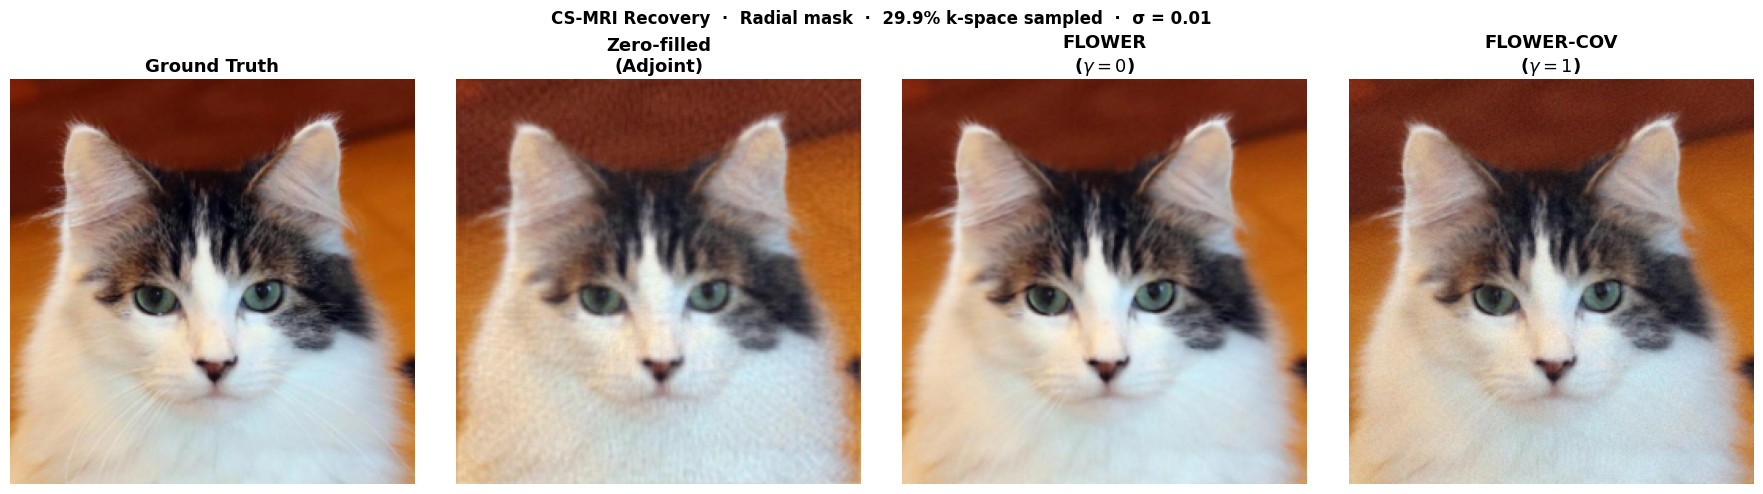

In [12]:
# ── Visualise Reconstruction Results ──────────────────────────────────────────
def to_numpy_img(t):
    """Convert a [1,C,H,W] or [C,H,W] tensor to a clippable [H,W,3] numpy array in [0,1]."""
    t = t.squeeze(0).detach().cpu().float()
    t = (t - t.min()) / (t.max() - t.min() + 1e-8)
    return t.permute(1, 2, 0).numpy()

sparsity = torch.sum(mask) / mask.numel()

panels = [
    ('Ground Truth',                          gt),
    ('Zero-filled\n(Adjoint)',                Ht(y)),
    ('FLOWER\n($\\gamma = 0$)',        x_flower),
    ('FLOWER-COV\n($\\gamma = 1$)',     x_flower_cov),
]

fig, axes = plt.subplots(1, 4, figsize=(18, 4.8))

for ax, (title, img) in zip(axes, panels):
    ax.imshow(to_numpy_img(img).clip(0, 1))
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.axis('off')

fig.suptitle(
    f'CS-MRI Recovery  ·  Radial mask  ·  {sparsity:.1%} k-space sampled  ·  σ = {sigma_noise}',
    fontsize=12, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()